# House Price Modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from folium import plugins
from scipy.stats import f_oneway, pointbiserialr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    TimeSeriesSplit,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from proteccion.models.model_utils import (
    evaluate_regression,
    log_mlflow_experiment,
    save_model,
    load_model,
)
from proteccion.utils.paths import data_raw_dir, reports_dir, models_dir
from proteccion.visualization.visualize import (
    plot_correlation_matrix,
    plot_distribution
)

sns.set_theme(style="darkgrid")

## Carga de datos

In [3]:
df = pd.read_csv(data_raw_dir("home_data.csv"))

# Convert date to datetime
df["date"] = pd.to_datetime(df["date"], errors='coerce')

# Quick check
print("shape:", df.shape)
print(df.dtypes)
display(df.head())

shape: (21613, 21)
id                        int64
date             datetime64[ns]
price                     int64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## EDA

In [4]:
display(df.describe().T)

,count,mean,min,25%,50%,75%,max,std
id,21613.0,4580301520.864988,1000102.0,2123049194.0,3904930410.0,7308900445.0,9900000190.0,2876565571.312057
date,21613,2014-10-29 04:38:01.959931648,2014-05-02 00:00:00,2014-07-22 00:00:00,2014-10-16 00:00:00,2015-02-17 00:00:00,2015-05-27 00:00:00,NaN
price,21613.0,540088.141905,75000.0,321950.0,450000.0,645000.0,7700000.0,367127.195968
bedrooms,21613.0,3.370842,0.0,3.0,3.0,4.0,33.0,0.930062
bathrooms,21613.0,2.114757,0.0,1.75,2.25,2.5,8.0,0.770163
sqft_living,21613.0,2079.899736,290.0,1427.0,1910.0,2550.0,13540.0,918.440897
sqft_lot,21613.0,15106.967566,520.0,5040.0,7618.0,10688.0,1651359.0,41420.511515
floors,21613.0,1.494309,1.0,1.0,1.5,2.0,3.5,0.539989
waterfront,21613.0,0.007542,0.0,0.0,0.0,0.0,1.0,0.086517
view,21613.0,0.234303,0.0,0.0,0.0,0.0,4.0,0.766318


missing per column:
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


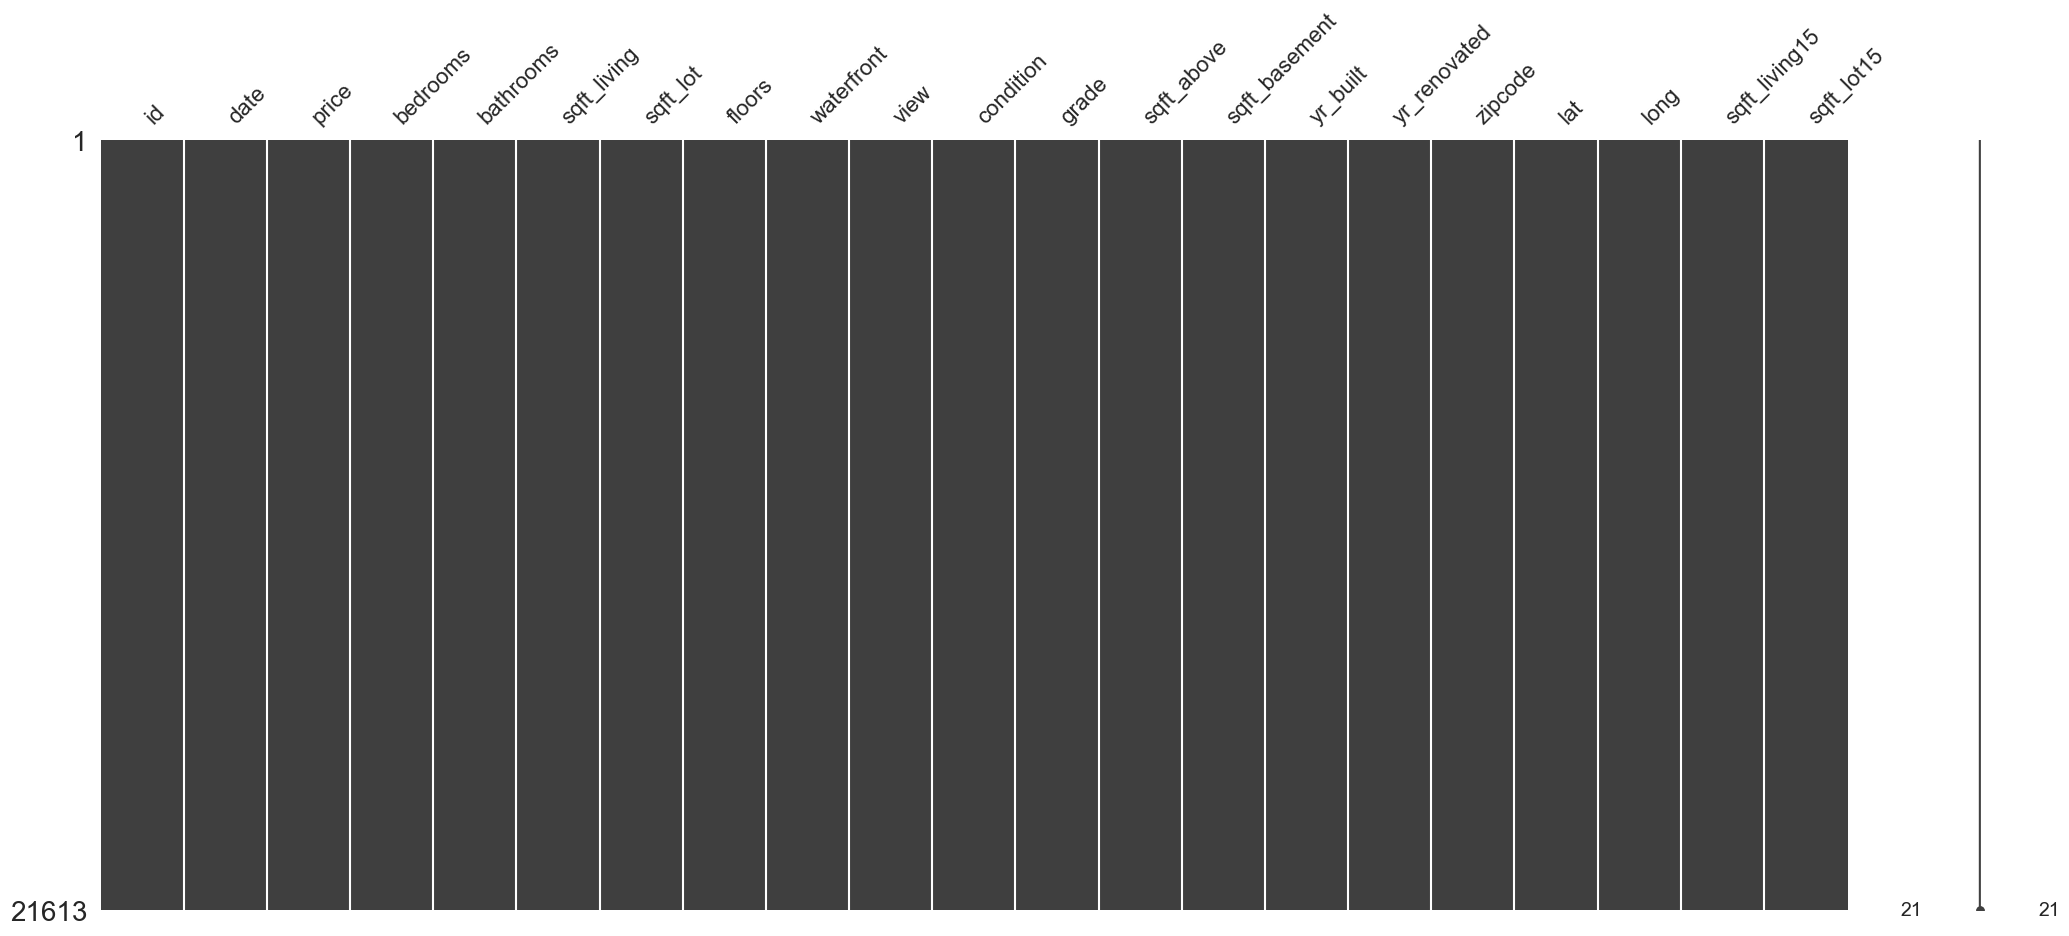

In [5]:
# Check for missing dates or other missing values
print("missing per column:\n", df.isna().sum())

# Visualize missing values
msno.matrix(df)
plt.show()

In [6]:
# Find duplicated recods
duplicated_ids = df[df["id"].duplicated()]

# Check for duplicated records
print(f"Duplicated records: {duplicated_ids.shape[0]}")

# # Inspect duplicated records
# for id in duplicated_ids["id"]:
#     print(id)
#     display(df[df["id"] == id])

# The duplicated records seem to be an update of the previous record
# We will drop the duplicated records keeping the record with the latest date
df = df.sort_values(by="date", ascending=False).drop_duplicates(subset="id")

Duplicated records: 177


### Distribution of price

price skew: 4.03610718616355


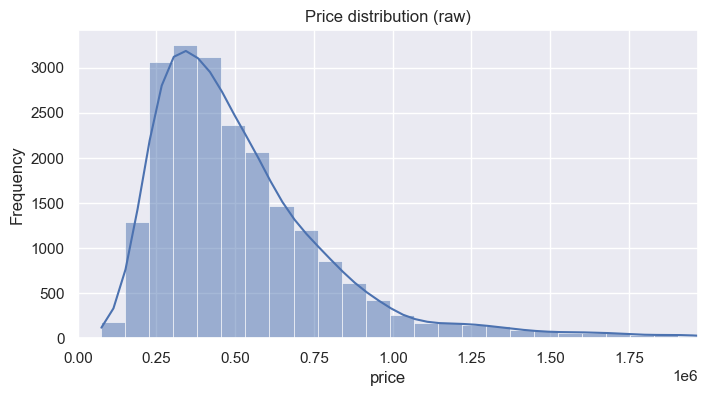

In [7]:
print("price skew:", df['price'].skew())
plot_distribution(
    data=df['price'],
    title="Price distribution (raw)",
    xlabel="price",
    bins=100,
    figsize=(8, 4),
    # zoom to 99th percentile to see central mass
    xlim=(0, df['price'].quantile(0.99))
)

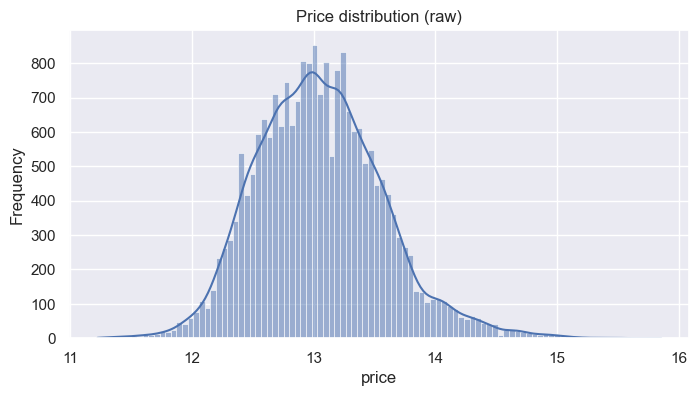

In [8]:
# Log-transform the price to reduce skewness
plot_distribution(
    data=np.log1p(df['price']),
    title="Price distribution (raw)",
    xlabel="price",
    bins=100,
    figsize=(8, 4),
)

### Abut the features

| Feature           | Tipo                 | Descripción                                                        | Importancia para el modelo                                                                                                                                                                                |
| :---------------- | :------------------- | :----------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **bedrooms**      | Numérica             | Número total de habitaciones.                                      | Influye directamente en el tamaño y utilidad de la vivienda (depende del área habitable). |
| **bathrooms**     | Numérica             | Número total de baños        | Refleja comodidad y nivel de equipamiento del hogar. Suele tener una relación positiva con el precio.                                               |
| **sqft_living**   | Numérica             | Superficie habitable interior (en pies cuadrados).                 | Es un predictor fuerte del precio: más área habitable tiende a implicar mayor valor. Mide el tamaño “útil” de la casa.                                                    |
| **sqft_lot**      | Numérica             | Área total del lote o terreno.                                     | Afecta el valor del suelo, especialmente en zonas suburbanas o de baja densidad. Su influencia es menor en áreas urbanas donde la tierra es más escasa.                                                   |
| **floors**        | Numérica             | Número de pisos o niveles de la casa.                              | Indica el diseño y el tamaño vertical del inmueble arquitectónico.                                                                                |
| **waterfront**    | Categórica (binaria) | Indica si la propiedad tiene vista o acceso directo al agua (0/1). | Fuerte indicador de lujo y exclusividad; propiedades frente al agua suelen tener precios significativamente más altos.                                                                                    |
| **view**          | Ordinal              | Valoración de la vista (0–4).                                      | Captura atractivo visual; propiedades con buenas vistas suelen tener mayor demanda y valor.                                                                                                               |
| **condition**     | Ordinal              | Estado general de la vivienda (1–5).                               | Refleja mantenimiento y habitabilidad. Afecta directamente la disposición del comprador a pagar.                                                                                                          |
| **grade**         | Ordinal              | Calificación del diseño y calidad de la construcción (1–13).       | Resume materiales, acabados y arquitectura. Generalmente está altamente correlacionado con el precio.                                                                                                                       |
| **sqft_above**    | Numérica             | Área construida sobre el nivel del suelo.                          | Mide el tamaño de la parte principal de la vivienda. Útil para distinguir casas con sótanos amplios.                                                                      |
| **sqft_basement** | Numérica             | Área del sótano habitable o no habitable.                          | Puede aumentar el valor si está acondicionado como espacio útil. Permite distinguir tipologías de vivienda.                                                                                               |
| **yr_built**      | Numérica             | Año de construcción.                                               | Permite capturar efecto del envejecimiento estructural; viviendas más nuevas tienden a valer más (aunque hay excepciones históricas o patrimoniales).                                                     |
| **yr_renovated**  | Numérica             | Año de última renovación (0 si nunca se renovó).                   | Las renovaciones suelen actualizar materiales e incrementar valor. Sirve para crear features derivados como “edad desde renovación”.                                                                      |
| **zipcode**       | Categórica           | Código postal o zona geográfica.                                   | Agrupa características del vecindario (seguridad, colegios, accesos, renta promedio). Suele ser uno de los predictores más importantes indirectos del precio.                                             |
| **lat**           | Numérica             | Latitud (posición geográfica).                                     | Junto con la longitud, permite capturar ubicación espacial continua, puede estar correlacionada con cercanía al centro urbano o zonas costeras.                                                                       |
| **long**          | Numérica             | Longitud (posición geográfica).                                    | Se usa junto con la latitud para aprender patrones espaciales. En modelos no lineales, el par (lat, long) es crucial para capturar efectos de localización.                                               |
| **sqft_living15** | Numérica             | Promedio del área habitable de las 15 casas vecinas.               | Representa el contexto del vecindario — viviendas rodeadas de casas grandes suelen tener precios más altos.                                                                                               |
| **sqft_lot15**    | Numérica             | Promedio del área del terreno de las 15 casas vecinas.             | También contextualiza el entorno físico del vecindario. Suele estar correlaciona con densidad y tipo de urbanización.                                                                                                 |

### Agrupación de características

* **Tamaño** : `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`
  : reflejan escala física y habitabilidad.
* **Calidad y estado** : `condition`, `grade`, `yr_built`, `yr_renovated`
  : capturan atributos constructivos y antigüedad.
* **Ubicación** : `zipcode`, `lat`, `long`
  : codifican el contexto geográfico y socioeconómico.
* **Características premium** : `waterfront`, `view`
  : indican exclusividad o atractivo visual.
* **Contexto del vecindario** : `sqft_living15`, `sqft_lot15`
  : reflejan el entorno y el “benchmark” local de precios.


### Análisis de tendencia temporal

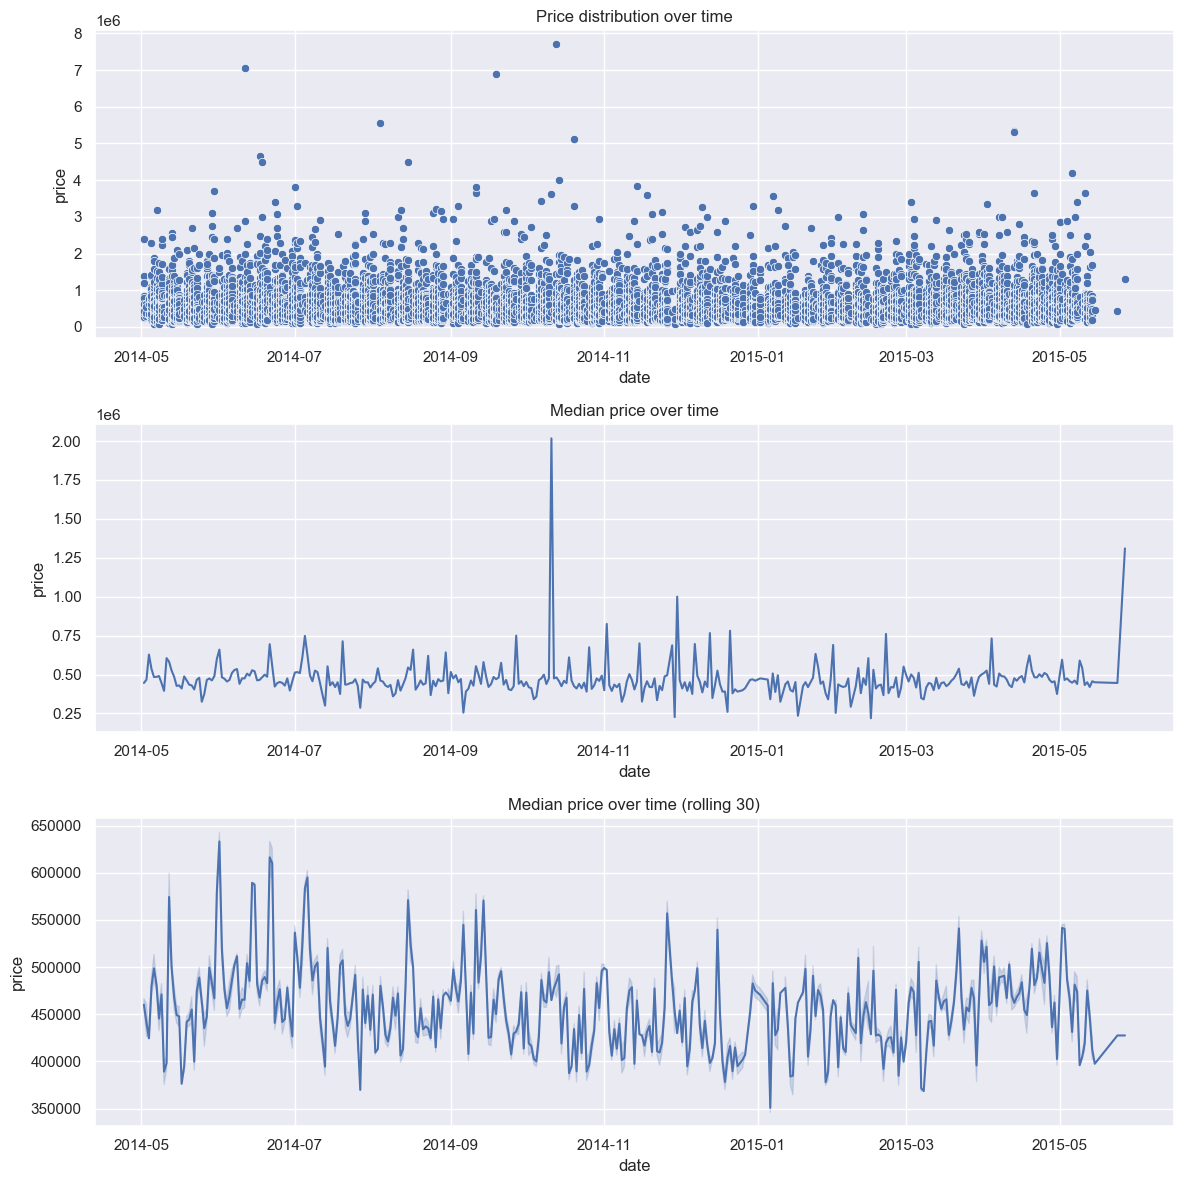

In [ ]:
df_sorted = df.sort_values('date')
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column
sns.scatterplot(
    x='date',
    y='price',
    data=df_sorted,
    ax=axes[0]
)
axes[0].set_title("Price distribution over time")

median_price = df.groupby("date")["price"].median().reset_index()
sns.lineplot(
    x='date',
    y='price',
    data=median_price,
    ax=axes[1]
)
axes[1].set_title("Median price over time")

rolling_median = df_sorted.rolling(30, on='date').median().dropna()
sns.lineplot(
    x='date',
    y='price',
    data=rolling_median,
    ax=axes[2]
)
axes[2].set_title("Median price over time (rolling 30)")

plt.tight_layout()
plt.show()

**Observaciones**
* Las figuras no muestran tendencias claras de aumento o disminución de precios.

### Transformaciones básicas

In [ ]:
# Sale year and month
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month

# Age at sale
df['age'] = df['sale_year'] - df['yr_built']
df['age'] = df['age'].clip(lower=0)  # avoid negatives if any

# Renovated flag and years since renov
df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['yrs_since_renovation'] = np.where(df['yr_renovated'] > 0, df['sale_year'] - df['yr_renovated'], 0)

# bedrooms per sqft (density feature)
df['bedrooms_per_sqft'] = df['bedrooms'] / df['sqft_living'].replace(0, np.nan)

# Encode zipcode as categorical numeric codes, keep NaN for unknowns
df['zipcode'] = pd.Categorical(df['zipcode']).codes
df.loc[df['zipcode'] == -1, 'zipcode'] = np.nan

**Observaciones**
* La edad (`age`) de la vivienda pouede ser un buen predictor del valor: las casas más nuevas suelen valer más, mientras que las más antiguas tienden a depreciarse (a menos que tengan valor histórico).

* No todas las casas se construyen nuevas; algunas se renuevan y mejoran significativamente su valor. La marcación `was_renovated` captura el efecto binario de si una casa fue renovada o no (0/1), útil para modelos lineales.

* La variable `yrs_since_renovation` agrega información temporal: las renovaciones recientes tienen más impacto que las antiguas.

* La variable `bedrooms_per_sqft` captura la densidad de habitaciones en relación al tamaño habitable, lo cual puede influir en la percepción de espacio y valor. Una alta densidad puede indicar espacios pequeños o mal distribuidos, lo que reduce el valor por metro cuadrado.

### Análisis de correlación

#### Correlación numérica y ordinal

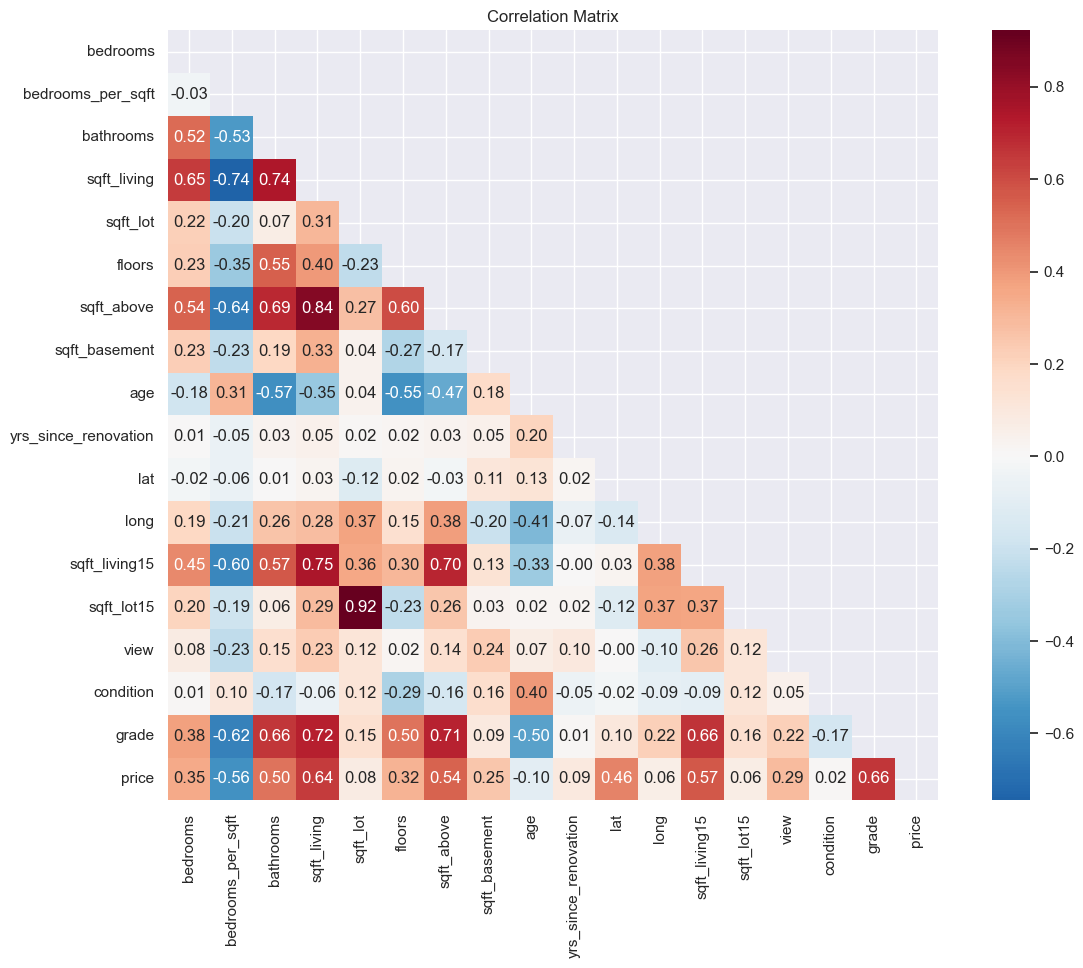

In [ ]:
num_ord = [
    'bedrooms',
    'bedrooms_per_sqft',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'sqft_above',
    'sqft_basement',
    'age',
    'yrs_since_renovation',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'view',
    'condition',
    'grade',
]

plot_correlation_matrix(
    df=df[num_ord + ['price']],
    figsize=(14, 10),
    method="spearman"
)

**Observaciones**
* Hay correlaciones fuertes (multicolinealidad) entre `sqft_living`, `sqft_above`, y `sqft_living15`, lo cual es esperado ya que todas miden aspectos del tamaño habitable. Tambien hay una alta correlacon positiva de `bathrooms` con `sqft_living` ya que casas mas grandes tienden a tener mas baños. Estas variables tambien tiene alta correlacion con el precio lo que las hace predictoras clave.
* `lat` tiene una correlacion positiva moderada con el precio, sugiriendo que la ubicación geográfica influye en el valor de la propiedad.
* `grade` también muestra una correlación significativa con el precio, reflejando la importancia de la calidad constructiva.
* `sqft_lot` y `sqft_lot15` muestran correlaciones más débiles con el precio, indicando que el tamaño del terreno es menos determinante que el área habitable.
* `bedrooms_per_sqft` tiene una correlación negativa con el precio, lo que sugiere que una mayor densidad de habitaciones puede reducir el valor percibido de la vivienda.

#### Binarias (Point-Biserial)

In [ ]:
# List of binary and numeric/ordinal variables
binary_cols = ['waterfront', 'was_renovated']
num_cols = num_ord + ['price']

results = []
for binary_col in binary_cols:
    for col in num_cols:
        r, p = pointbiserialr(df[binary_col], df[col])
        results.append({
            'binary_feature': binary_col,
            'numeric_feature': col,
            'correlation_r': round(r, 3), # type: ignore
            'p_value': f"{p:.3e}"
        })

# Convert to DataFrame
corr_df = pd.DataFrame(results)

# Sort by absolute correlation
corr_df['|r|'] = corr_df['correlation_r'].abs()
corr_df = corr_df.sort_values(by='|r|', ascending=False)
display(corr_df.head(10))

,binary_feature,numeric_feature,correlation_r,p_value,|r|
27,was_renovated,yrs_since_renovation,0.757,0.000e+00,0.757
14,waterfront,view,0.403,0.000e+00,0.403
17,waterfront,price,0.267,0.000e+00,0.267
26,was_renovated,age,0.226,1.706e-245,0.226
35,was_renovated,price,0.126,4.923e-77,0.126
9,waterfront,yrs_since_renovation,0.105,2.452e-53,0.105
32,was_renovated,view,0.104,2.093e-52,0.104
3,waterfront,sqft_living,0.104,1.580e-52,0.104
1,waterfront,bedrooms_per_sqft,-0.088,9.946e-38,0.088
12,waterfront,sqft_living15,0.087,6.214e-37,0.087


**Observaciones**
* La variable `waterfront` muestra una correlación positiva significativa con el precio de las viviendas. Esto indica que las propiedades con vista o acceso al agua tienden a tener precios considerablemente más altos en comparación con aquellas que no cuentan con esta característica.
* Tambien se observa que `waterfront` tiene una correlación moderada con `view`, sugiriendo que las propiedades frente al agua suelen tener mejores vistas y una mayor calidad constructiva.

#### Categóricas

In [ ]:
def eta_squared(x, y):
    categories = [y[x == cat] for cat in np.unique(x)]
    f_val, p_val = f_oneway(*categories)
    ss_between = sum(len(cat)*(cat.mean() - y.mean())**2 for cat in categories)
    ss_total = sum((y - y.mean())**2)
    return ss_between / ss_total, p_val


eta, p = eta_squared(df['zipcode'], df['price'])
print(f"η²={eta:.3f}, p={p:.3e}")

η²=0.407, p=0.000e+00


**Observaciones**
* La variable `zipcode` tiene un valor de eta cuadrado relativamente alto, lo que indica que la ubicación geográfica es un factor importante que influye en el precio de las viviendas. Diferentes códigos postales representan diferentes vecindarios con características socioeconómicas variadas, lo que afecta significativamente los valores de las propiedades.

#### Interacciones espaciales

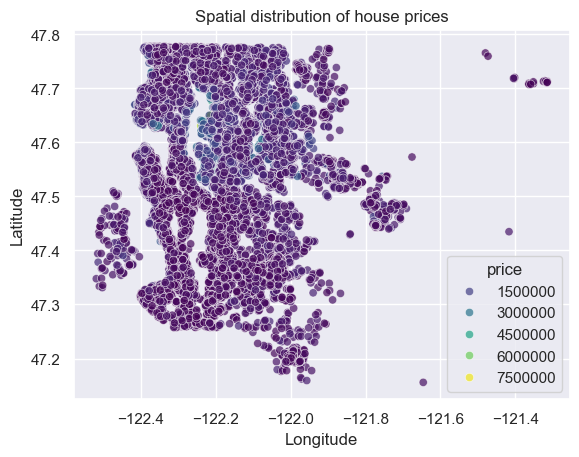

In [ ]:
sns.scatterplot(data=df, x='long', y='lat', hue='price',
                palette='viridis', alpha=0.7)
plt.title("Spatial distribution of house prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Generate interactive map of house prices

In [ ]:
# # Prepare data
# df_map = df.dropna(subset=['lat', 'long', 'price']).copy()

# # Map center
# center = [df_map['lat'].mean(), df_map['long'].mean()]

# # Create map
# m = folium.Map(location=center, zoom_start=11, tiles='CartoDB positron')

# # Continuous colormap for price
# vmin, vmax = df_map['price'].min(), df_map['price'].max()
# colormap = cm.LinearColormap(
#     ['green', 'yellow', 'red'],
#     vmin=vmin,
#     vmax=vmax,
#     caption='Price'
# )
# colormap.add_to(m)

# # Use a MarkerCluster for performance
# marker_cluster = plugins.MarkerCluster(name='houses').add_to(m)

# # Add points as CircleMarkers colored by price
# for _, row in df_map.iterrows():
#     price = row['price']
#     color = colormap(price)
#     popup_html = f"ID: {row.get('id','N/A')}<br>Price: ${price:,.0f}<br>Lat: {row['lat']:.5f}<br>Long: {row['long']:.5f}"
#     folium.CircleMarker(
#         location=[row['lat'], row['long']],
#         radius=4,
#         color=color,
#         fill=True,
#         fill_color=color,
#         fill_opacity=0.7,
#         popup=folium.Popup(popup_html, max_width=250)
#     ).add_to(marker_cluster)

# m.save(reports_dir("house_prices_map.html"))
# # display(m)

#### Resumen visual

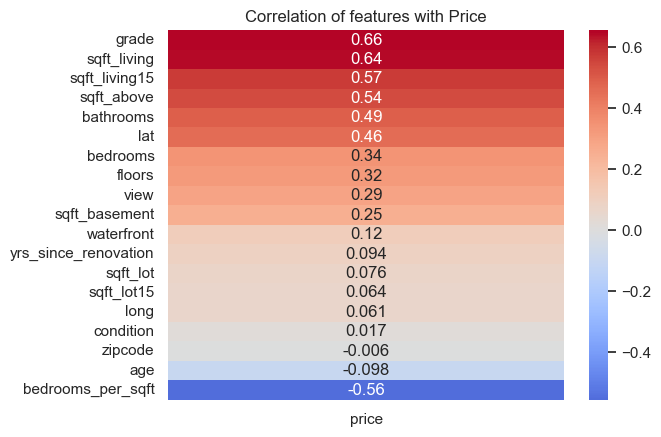

In [ ]:
cols = num_ord + ['waterfront', 'zipcode'] + ['price']
price_corr_df = df[cols].copy()

# Compute Spearman correlation matrix
mixed_corr: pd.DataFrame = pg.rcorr(price_corr_df[cols], method='spearman')

# Build a properly typed Series first, then sort using the ascending keyword to avoid positional-argument issues
price_series = mixed_corr.loc['price'].drop('price')
price_series = price_series.astype(float)
price_series = price_series.sort_values(ascending=False) # type: ignore

price_series = pd.DataFrame(price_series)

sns.heatmap(
    price_series,
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title("Correlation of features with Price")
plt.show()

## Transformación de la variable objetivo

In [ ]:
# Log-transform the price to reduce skewness and use it as target variable
df['log_price'] = np.log1p(df['price'])

**Observaciones**
* El precio (`price`) suele tener una distribución fuertemente sesgada a la derecha (muchas casas promedio y pocas extremadamente caras). La transformación logarítmica permite redicir esta asimetría (skewness) y la influencia de outliers.

## Selección de características

In [ ]:
structure_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_basement'
]
condition_features = [
    'grade', 'yrs_since_renovation'
]
location_features = [
    'lat', 'long', 'view', 'waterfront'
]
lot_features = ['sqft_lot']
temporal = ['age']

features = (
    structure_features +
    condition_features +
    location_features +
    lot_features +
    temporal
)

# Split features by type
numeric_features = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'view',
    'grade',
    'sqft_basement',
    'lat',
    'long', 
    'age','yrs_since_renovation'
]
categorical_features = ['waterfront']  # waterfront and was_renovated are low-cardinality

### Validacion mediante VIF

El Factor de Inflación de la Varianza (VIF) es una medida que cuantifica la severidad de la multicolinealidad en un conjunto de variables independientes en un modelo de regresión. Un VIF alto indica que una variable está altamente correlacionada con otras variables, lo que puede distorsionar las estimaciones del modelo.

Interpretación de los valores de VIF:
* VIF = 1: No hay correlación entre la variable independiente y las demás variables.
* 1 < VIF < 5: Correlación moderada; generalmente aceptable.
* VIF ≥ 5: Correlación alta; se debe considerar eliminar o transformar la variable.

In [ ]:
# Select only the independent variables for VIF calculation.
X = df[features].dropna()

# Add a constant term (intercept) to the independent variables
# This is important for accurate VIF calculation in statsmodels.
X: pd.DataFrame = add_constant(X) # type: ignore

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif_data[vif_data["feature"] != "const"].sort_values(by="VIF", ascending=False))

,feature,VIF
3,sqft_living,5.032188
2,bathrooms,3.292184
6,grade,3.117378
13,age,2.087296
4,floors,1.948389
5,sqft_basement,1.928657
1,bedrooms,1.643699
9,long,1.415460
10,view,1.392015
11,waterfront,1.206150


**Observaciones**
* Las variables `sqft_living` y `bathrooms` presentan VIFs moderados, indicando cierta multicolinealidad con otras características. Sin embargo, sus valores no son lo suficientemente altos como para justificar su eliminación inmediata del modelo. Se decide mantener estas variables en el conjunto de características seleccionadas ya que `sqft_living` es un predictor clave del precio y `bathrooms` aporta información relevante sobre la comodidad de la vivienda.

## Selección de un modelo inicial

In [ ]:
# To avoid temporal leakage I'll use a cutoff date.
cutoff = df['date'].quantile(0.80)
train_df = df[df['date'] <= cutoff].copy()
test_df = df[df['date'] > cutoff].copy()

X_train, X_test, y_train, y_test = (
    train_df[features],
    test_df[features],
    train_df['log_price'],
    test_df['log_price']
)

In [ ]:
# shared numeric transformer (impute -> scale)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# shared preprocessor to avoid repetition
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore',
     sparse_output=False), categorical_features)
], remainder='drop')

# Candidate pipelines
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LinearRegression())
])

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

pipe_hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('hgb', HistGradientBoostingRegressor(random_state=42))
])


# Evaluation function
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, do_print=True):

    # Fit on train, predict on test
    pipeline.fit(X_train, y_train)
    pred_log = pipeline.predict(X_test)

    # Basic metrics in log-space
    results_log = evaluate_regression(y_test, pred_log)

    # Convert to price units for interpretability
    pred_price = np.expm1(pred_log)
    actual_price = np.expm1(y_test)
    results_price = evaluate_regression(actual_price, pred_price)

    if do_print:
        print(f"R2: {results_log['r2']:.4f}")
        print(f"Log-units -> MAE: {results_log['mae']:.4f}, RMSE: {results_log['rmse']:.4f}")
        print(f"Price-units -> MAE: ${results_price['mae']:,.0f}, RMSE: ${results_price['rmse']:,.0f}")
    return {
        'mae_log': results_log['mae'],
        'rmse_log': results_log['rmse'],
        'r2': results_log['r2'],
        'mae_price': results_price['mae'],
        'rmse_price': results_price['rmse'],
        'y_pred_log': pred_log,
        'y_pred_price': pred_price,
    }

In [ ]:
print("Baseline model evaluation on test set:")
print("\nEvaluating Linear Regression")
res_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test)

print("\nEvaluating Random Forest")
res_rf = evaluate_model(pipe_rf, X_train, y_train, X_test, y_test)

print("\nEvaluating HistGradientBoosting")
res_hgb = evaluate_model(pipe_hgb, X_train, y_train, X_test, y_test)

Baseline model evaluation on test set:

Evaluating Linear Regression
R2: 0.7317
Log-units -> MAE: 0.2084, RMSE: 0.2691
Price-units -> MAE: $119,496, RMSE: $197,352

Evaluating Random Forest
R2: 0.8644
Log-units -> MAE: 0.1418, RMSE: 0.1913
Price-units -> MAE: $79,865, RMSE: $145,168

Evaluating HistGradientBoosting
R2: 0.8720
Log-units -> MAE: 0.1400, RMSE: 0.1859
Price-units -> MAE: $77,860, RMSE: $136,551


### Resumen de modelos probados

| Modelo                   | R²     | MAE ($)  | RMSE ($) | Interpretación                                                                                                                   |
|--------------------------|--------|----------|----------|----------------------------------------------------------------------------------------------------------------------------------|
| **Linear Regression**    | 0.7317 | $119,496 | $197,352 | Modelo base. Explica ~73% de la varianza. Error promedio ~$120k. Capta bien la tendencia, pero no relaciones no lineales.        |
| **Random Forest**        | 0.8644 | $79,865  | $145,168 | Mejora clara. Captura relaciones no lineales y variables geográficas (`lat`, `long`, `waterfront`). Explica ~86% de la varianza. |
| **HistGradientBoosting** | 0.8720 | $77,860  | $136,551 | Mejor desempeño. Modelo más preciso y robusto. Reduce error medio en ~35% frente al lineal. Explica ~87% de la varianza.         |

El modelo HistGradientBoosting es el más adecuado para estimar el valor de mercado de las viviendas. Explicando el 87% de la variabilidad en los precios, con un error medio de ≈ $78,000, lo cual es competitivo y consistente con la naturaleza ruidosa del mercado inmobiliario.

## Optimización de hiperparámetros

In [ ]:
# Hyperparameter tuning for HistGradientBoosting
param_dist = {
    'hgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'hgb__max_iter': [100, 200, 300],
    'hgb__max_depth': [3, 5, 7, None],
    'hgb__min_samples_leaf': [20, 50, 100],
    'hgb__l2_regularization': [0.0, 0.1, 0.5, 1.0]
}

# Use TimeSeriesSplit to preserve temporal order during CV
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    pipe_hgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit search on training data only (time-aware CV)
random_search.fit(X_train, y_train)
best_hgb = random_search.best_estimator_
print("Best HGB params:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best HGB params: {'hgb__min_samples_leaf': 20, 'hgb__max_iter': 200, 'hgb__max_depth': None, 'hgb__learning_rate': 0.05, 'hgb__l2_regularization': 1.0}


### Tracking con MLflow (Opcional)

In [ ]:
# Track best model performance using mlflow
final_model: Pipeline = best_hgb # type: ignore
res_hgb_tuned = evaluate_model(final_model, X_train, y_train, X_test, y_test)
# log_mlflow_experiment(
#     model=best_hgb,
#     params=random_search.best_params_,
#     metrics=res_hgb_tuned,
#     experiment_name="House Price Prediction",
#     run_name="HGB RandomizedSearchCV",
#     model_name="HistGradientBoostingRegressor_RandomizedSearchCV",
# )

R2: 0.8734
Log-units -> MAE: 0.1393, RMSE: 0.1849
Price-units -> MAE: $77,618, RMSE: $135,746


In [ ]:
# Save the final model
save_model(
    model=final_model,
    filepath=models_dir("house_price_hgb_model.pkl"),
    engine="pickle"
)

## Selección de viviendas para inversión

Para selcecionar viviendas con potencial de inversión, se considera **Comprar barato y vender caro**: Buscar viviendas cuyo precio actual esté significativamente por debajo del valor estimado por el modelo. Estas propiedades tienen un mayor potencial de apreciación y ganancia al momento de la venta.

In [ ]:
# Load the model back (test)
final_model: Pipeline = load_model(
    filepath=models_dir("house_price_hgb_model.pkl"),
    engine="pickle"
)

# Predict on test set (log scale)
log_pred_test = final_model.predict(X_test)
# Convert back to price units
pred_price_test = np.expm1(log_pred_test)
actual_price_test = np.expm1(y_test)

# Residuals in price units
residuals = pred_price_test - actual_price_test
results = test_df.copy()
results['predicted_price'] = pred_price_test
results['actual_price'] = actual_price_test
results['residual'] = residuals
results['residual_pct'] = results['residual'] / results['actual_price']

# Sort by highest positive residual (model predicts higher market value than observed price) -> potential undervalued
candidates = results.sort_values('residual', ascending=False)

# Show top candidate(s)
print("Top investment candidates (model predicts higher market price than actual):")
display(candidates.head(5))


Top investment candidates (model predicts higher market price than actual):


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sale_month,age,was_renovated,yrs_since_renovation,bedrooms_per_sqft,log_price,predicted_price,actual_price,residual,residual_pct
4581,5460600110,2015-04-23,1050000,6,4.00,5310,12741,2.0,0,2,...,4,48,0,0,0.001130,13.864302,1.790981e+06,1050000.0,740981.463454,0.705697
8450,121039042,2015-03-13,425000,3,2.75,3610,107386,1.5,1,3,...,3,97,1,53,0.000831,12.959847,1.162601e+06,425000.0,737600.880893,1.735531
5749,6744701310,2015-04-15,1850000,4,2.50,3830,11972,1.0,1,4,...,4,34,0,0,0.001044,14.430697,2.573447e+06,1850000.0,723446.643516,0.391052
18914,9253900408,2015-04-08,1400000,3,2.75,3130,19530,1.0,1,4,...,4,68,1,31,0.000958,14.151984,1.918038e+06,1400000.0,518037.600118,0.370027
8568,8653600100,2015-03-30,750000,5,2.50,3120,15593,2.0,0,4,...,3,29,0,0,0.001603,13.527830,1.264795e+06,750000.0,514794.997540,0.686393


## Conclusiones

* El proceso de modelado se abordó desde una perspectiva de entendimiento de las caracteristicas de las viviendas y su impacto en el valor, priorizando explicabilidad y entendimiento del negocio.
* Se ha desarrollado un modelo robusto de predicción de precios de viviendas utilizando técnicas avanzadas de machine learning, logrando un R² de 0.8734 con un error medio absoluto de $77,618.
* El modelo HistGradientBoosting demostró ser el más efectivo para capturar las complejas relaciones entre las características de las viviendas y sus precios de mercado.
* Si bien es posible implementar medidas más robustas para la selección de características y optimización de hiperparámetros, el enfoque adoptado equilibró precisión y simplicidad, facilitando la interpretación y aplicación práctica del modelo en escenarios reales de inversión inmobiliaria.
